Like in the Part 1, we are taking on the role of as an analyst for a book company. The company has provided us more data on some of its 2019 book sales, and it wants us to extract some usable knowledge from it. It launched a new program encouraging customers to buy more books on July 1st, 2019, and it wants to know **if this new program was successful at increasing sales and improving review quality**. As the analyst, this will be our job to figure out for the project.

[Suggested solutions to the project](https://github.com/dataquestio/solutions/blob/master/Mission516Solutions.Rmd)

As with any data analysis project, we should try to frame things in terms of a workflow. This workflow will give us a solid framework to approach any problem that we might encounter. Before we even think about data analysis, we should explore the data itself and make note of any potential problems that we might run into.

Like in the last project, we're dealing with review data. This review data was in the form of strings, which required some extra cleaning for us to calculate any meaningful summaries from it.

### Data Exploration

`# How big is the dataset?
dim(sales)`

`# What are the column names?
colnames(sales)`

* The `date` column shows the date that the order of books was made. This will help us distinguish between orders that were made before and after the new program was implemented. 
* `quantity` describes how many books were made, and 
* `user_submitted_review` looks like it's a hand typed review of the books themselves. 
* `customer_type` indicates whether or not the customer was an individual or a business. It seems that the company has started selling in bulk to other business too.

`# What are the types of all the columns?
for (col in colnames(sales)) {
  paste0(col, " : ", typeof(sales[[col]])) %>% print
}`

`# Is there missing data anywhere?
for (col in colnames(sales)) {
  paste0(col, 
         ", number of missing data rows: ", 
         is.na(sales[[col]]) %>% sum) %>% print
}`

We found that there were two columns that had missing data. The first is the `user_submitted_review` column, which contains the review left by the customer. The second is `total_purchased`, which represents how many books were purchased by the customer.

For this project, we're going to handle these two columns differently. The reason for this is that we care a lot more about the `total_purchased` column is because it contains the actual information on book sales. We want to figure out if the company's new program helped to improve sales. In order to keep as much information on sales as possible, we're going to take a different approach to handling missing data here.

In short, we're going to to remove any rows that have missing data in `user_submitted_review`. We've done this in the previous project, so our code to get rid of these rows will look similar.

For `total_purchased`, we're going to use a slightly more sophisticated approach. We are going to replace all of the `NA` values with an average value that we calculate from the complete dataset. Filling in missing data with average values is useful because they are often the best guesses for what the purchase would have been. Humans do this frequently in everyday life too. If someone asked us how much time we slept each day, we're more likely than not to answer with the average amount of time we sleep in a week. We're going to apply the same concept here.

### Handling Missing Data


`# Remove the rows with no user_submitted_review
complete_sales <- sales %>% 
  filter(
    !is.na(user_submitted_review)
  )`
    
`# Calculate the mean of the total_purchased column, without the missing values
purchase_mean <- complete_sales %>% 
  filter(!is.na(total_purchased)) %>% 
  pull(total_purchased) %>% 
  mean`
    
`# Assign this mean to all of the rows where total_purchased was NA
complete_sales <- complete_sales %>% 
  mutate(
    imputed_purchases = if_else(is.na(total_purchased), 
                                purchase_mean,
                                total_purchased)
  )`

String data can be incredibly difficult to work with, compared to the ease of handling numeric data. One reason for this is that there are several languages, and many, many words within just a single language. Combine this with the fact that humans can also make errors when writing, and we get some messy data.

The `user_submitted_review` column contains reviews in the form of sentences. Ultimately, we want to be able to classify reviews as either positive or negative. This will allow us to count the number of negative or positive reviews in the analysis part of the workflow. We'll perform the cleaning and processing necessary to turn each of the review sentences into the classifications we want.

# Processing Review Data

`complete_sales %>% pull(user_submitted_review) %>% unique`

The reviews range from outright hate ("Hated it") to positive ("Awesome!"). We'll create a function that uses a `case_when()` function to produce the output. `case_when()` functions can be incredibly bulky in cases where there's many options, but housing it in a function to `map` can make our code cleaner.

`is_positive <- function(review) {
  review_positive = case_when(
  str_detect(review, "Awesome") ~ TRUE,
  str_detect(review, "OK") ~ TRUE,
  str_detect(review, "Never") ~ TRUE,
  str_detect(review, "a lot") ~ TRUE,
  TRUE ~ FALSE # The review did not contain any of the above phrases
  )
}`

`complete_sales <- complete_sales %>% 
  mutate(
    is_positive = unlist(map(user_submitted_review, is_positive))
  )`

With the review data and order quantities processed into a usable form, we can finally make a move towards answering the main question of the analysis, **Was the new book program effective in increasing book sales?** The program started on July 1st, 2019, and the data we have contains all of the sales for 2019. There are still some preparatory steps we need to take before performing the analysis, so we'll do these first before conducting the analysis.

* **First**, the dates are currently represented in string form. These must be properly formatted before we can make any comparisons based on date and time.

* **Second**, we need a clear way to distinguish between sales that happen before the program starts and those that happen after. We need to distinguish between these two groups so that we can use what we've learned to more easily calculate the summary values we want from the data.

* And **finally**, this analysis should be put into a neat form that can be easily read and understood by anyone looking at it. This type of analysis is most efficiently done using a combination of the [`group_by()` function](https://dplyr.tidyverse.org/reference/group_by.html) and the [`summarize()` function](https://dplyr.tidyverse.org/reference/summarise.html). If we had some column in the dataset that described what group a row belongs to (i.e. a column named `group`), we could vectorize summary functions on groups with `summarize()`.

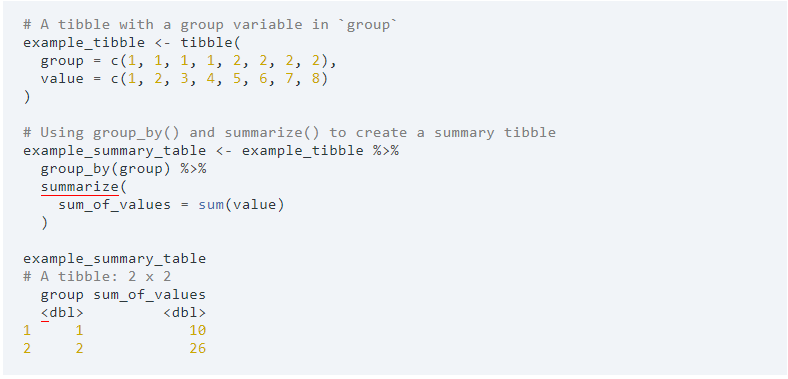

# Comparing Book Sales Between Pre- and Post-Program Sales


`# conversion of the date column`

`complete_sales <- complete_sales %>% 
  mutate(
    date_status = if_else(mdy(date) < ymd("2019/07/01"), "Pre", "Post")
  )`

`# Sales that happen before July 1, 2019 and sales that happen after this date.`

`complete_sales %>% 
  group_by(date_status) %>% 
  summarize(
    books_purchased = sum(imputed_purchases)
  )`

It doesn't seem that the program has increased sales. Maybe there were certain books that increased in sales?


`complete_sales %>% 
  group_by(date_status, title) %>% 
  summarize(
    books_purchased = sum(imputed_purchases)
  ) %>% 
  arrange(title, date_status)`

It turns out that certain books actually got more popular after the program started! R For Dummies and Secrets of R For Advanced Students got more popular.

In data analysis, it's common to have several subgroups that we want to compare. In the above step, we just compared sales that were before and after July 1, 2019. It's possible that individiual customers responded better to the program and bought more books in response to the program. Or, it could have been businesses that bought more books. In order to explore this sub-analysis, we also need to divide up the sales before and after July 1, 2019 into sales that were for individuals versus businesses

`# Comparing Book Sales Within Customer Type`

`complete_sales %>% 
  group_by(date_status, customer_type) %>% 
  summarize(
    books_purchased = sum(imputed_purchases)
  ) %>% 
  arrange(customer_type, date_status)`
  
Based on the table, it looks like businesses started purchasing more books after the program! There was actually a drop in individual sales.

The last question that we need to answer with the data is, **Did review scores improve as a result of the program?** We'll need to use the new column that we created to decide whether or not a review was positive or negative. This analysis will look much like our analysis on purchase quantity. This is not a coincidence! A lot of analyses we will perform will require comparing two groups together based on some quantity, whether it is the number of books or positive reviews. The `group_by()` function in combination with `summarize()` is an incredibly useful tool for approaching this type of comparison analysis. Most of our hard work centered on getting the data into a useable form. Examples includee transforming sentences into a classification and imputing the missing purchase quantities.

As we learn more programming, we will start to recognize that certain function are good for a particular situation. This recognition comes with lots of practice.

`# Comparing Review Sentiment Between Pre- and Post-Program Sales`

`complete_sales %>% 
  group_by(date_status) %>% 
  summarize(
    num_positive_reviews = sum(is_positive)
  )`

There's slightly more reviews before the program, but this difference seems negigible.


If we're interested in taking the analysis a bit further, here are some things we might want to consider doing:

* We imputed all of the missing purchase quantity values using just the average purchase quantity in the entire dataset. This worked out for us, but it totally eliminates any information about the books themselves. It might be better to compute the average purchase quantity for each book instead, and impute these values for the books instead.

* Is there any relationship between month and the amount of books that were sold? We focused our attention on a new program, but we can also perform a similar analysis based on the month and try to look for any trends that are associated with a smaller unit of time.